In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\wangj\Anaconda3\envs\ee_py3\lib\

In [2]:
ee.Initialize()

In [3]:
# append upper folder into sys-path during run time so we can
# import our own moduls
sys.path.append('../.')

# import the temporal_consistency_check class
from BackGround_modules.Class_5_Temporal_consistency_check import Temporal_consistency_check
from BackGround_modules.Class_3_Calculate_the_accuracy import Accuracy_assesment

In [4]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

len_landsat_1990_2013 = 8
len_sentinel_2014_2019 = 2

In [5]:
mask_years = [2016,2019]
original_range = ['2014_2016','2017_2019']

sentinel_urban_threshold = 5
cross_fold_threshold = 4

In [6]:
sample_path  = 'users/wangjinzhulala/China_built_up/04_sample_train_test_split'
img_path     = 'users/wangjinzhulala/China_built_up/05_primary_classification'
img_out_path = 'users/wangjinzhulala/China_built_up/06_temporal_corrected_classification'

In [7]:
region_cn = '西北'
region_en = 'xibei'

In [8]:
# import north_china_plain boundary
Region =  ee.FeatureCollection("users/wangjinzhulala/China_built_up/01_Boundary_shp/China_zone")\
            .filterMetadata('NAME1','equals',region_cn)

In [9]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

### Import Classified_img

##### First use sentinel_urban as mask to erase inconsistenty pixel in [2014-2016,2017-2017]

In [10]:
# import the sentinel-urban data
sentine_urban = [ee.Image(f'COPERNICUS/Landcover/100m/Proba-V-C3/Global/{year}').select("urban-coverfraction") 
                 for year in mask_years]

In [11]:
# fetch the original imgs of [2014-2016,2017-2017]

original_maps_to_be_masked = []

for year in original_range:
    
    imgs = [ee.Image(f"{img_path}/Spectrum_Normalize_Fourier_Terrain_Meterology_{region_en}_{year}_{seed}") 
            for seed in range(10)]
    
    ten_folds_check = ee.ImageCollection(imgs).sum().gte(cross_fold_threshold)
    
    original_maps_to_be_masked.append(ten_folds_check)


# use the threshold to construct the urban mask
urban_masks = [img.gte(sentinel_urban_threshold).clip(Region) for img in sentine_urban]

# use the mask to update original img
original_maps_update = [original.multiply(mask) for original,mask in zip(original_maps_to_be_masked,urban_masks)]
original_maps_update[0] = original_maps_update[0].multiply(original_maps_update[1])

In [12]:
# import the original classified imgs
Classified_img_1990_2013 = []

for year in year_range[:-2]: 
    
    imgs = [ee.Image(f"{img_path}/Spectrum_Normalize_Fourier_Terrain_Meterology_{region_en}_{year}_{seed}") 
            for seed in range(10)]
    
    ten_folds_check = ee.ImageCollection(imgs).sum().gte(4)
    
    Classified_img_1990_2013.append(ten_folds_check)

# add the masked imgs to img-list
Classified_imgs = Classified_img_1990_2013 + original_maps_update

### Perform temporal consistency check

In [13]:
# get the checked results
Iteration_num = 10
Window_size = [2,3,4,5,6]
modes = ['only_forward'] #['backward_forward','forward_backward','only_forward','only_backward']

Check_df_list = []

for window in Window_size:
    for mode in modes:
    
        # get the checked classification imgs, here they are stored in a dictionary
        Iter_temporal_check_instaces = Temporal_consistency_check(Classified_imgs,window,Iteration_num)\
                                        .Iterate_the_check(mode = mode)

        # convert the Iter_temporal_check_instaces to a Dataframe
        Check_instances = pd.DataFrame(Iter_temporal_check_instaces).T
        Check_instances.columns = year_range

        # Add the window-size and iteration-num to the df
        Check_instances['Mode'] = [mode] * Iteration_num
        Check_instances['Window'] = [window] * Iteration_num
        Check_instances['Iteration'] = range(1,Iteration_num+1)

        # Reorder the columns
        cols = Check_instances.columns
        Check_instances = Check_instances[list(cols[-3:]) + list(cols[:-3])] 

        # add the checked df into list
        Check_df_list.append(Check_instances)

================  Check Report  ================
Check length is    ---> 2
Check weights are  ---> [2, 1]
Check threshold is ---> 3
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 3
Check weights are  ---> [3, 1, 1]
Check threshold is ---> 4
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 4
Check weights are  ---> [4, 1, 1, 1]
Check threshold is ---> 6
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 5
Check weights are  ---> [5, 1, 1, 1, 1]
Check threshold is ---> 7
Check iteration is ---> 10
================  Check Report  ================
Check length is    ---> 6
Check weights are  ---> [6, 1, 1, 1, 1, 1]
Check threshold is ---> 9
Check iteration is ---> 10


In [14]:
# merge all instace_df together
Check_df = pd.concat(Check_df_list)
Check_df.reset_index(inplace=True,drop=True)

##### Transform the Check_sample into long format so each row is an observation with spicific window-iteration-year condition

In [15]:
# attach Check_sample to the Check_instaces_long 
Check_instaces_long = pd.DataFrame(Check_df.set_index(['Mode','Window','Iteration']).stack()).reset_index()
Check_instaces_long.columns = ['Mode','Window','Iteration','year','Image']

In [16]:
Check_instaces_long

,Mode,Window,Iteration,year,Image
0,only_forward,2,1,1990_1992,"ee.Image({\n ""functionInvocationValue"": {\n ..."
1,only_forward,2,1,1993_1995,"ee.Image({\n ""functionInvocationValue"": {\n ..."
2,only_forward,2,1,1996_1998,"ee.Image({\n ""functionInvocationValue"": {\n ..."
3,only_forward,2,1,1999_2001,"ee.Image({\n ""functionInvocationValue"": {\n ..."
4,only_forward,2,1,2002_2004,"ee.Image({\n ""functionInvocationValue"": {\n ..."
...,...,...,...,...,...
495,only_forward,6,10,2005_2007,"ee.Image({\n ""functionInvocationValue"": {\n ..."
496,only_forward,6,10,2008_2010,"ee.Image({\n ""functionInvocationValue"": {\n ..."
497,only_forward,6,10,2011_2013,"ee.Image({\n ""functionInvocationValue"": {\n ..."
498,only_forward,6,10,2014_2016,"ee.Image({\n ""functionInvocationValue"": {\n ..."


##### Create the Mosaic image from all temporal-checked imgs

In [17]:
Mosaic_img = {}

for window in Window_size:
    for iteration in range(1,Iteration_num+1):
        # get the temporal_checked imgs
        Temporal_checked_select  = Check_instaces_long[(Check_instaces_long['Iteration'] == iteration)&\
                                                       (Check_instaces_long['Window']    == window)     ]['Image'].values
        # reclassify the classification img
        Temporal_checked_select_re = [(i,img)[1].remap([0,1],[0,10-(i,img)[0]]) 
                                      for i,img in enumerate(Temporal_checked_select)]

        # mosaic all checked imgs together
        Classification_Mosaic = ee.ImageCollection(Temporal_checked_select_re).max()
        
        # store the img to dict
        Mosaic_img[(window,iteration)] = [Classification_Mosaic]

In [18]:
# convert the mosaic classification into a dataframe and format the column names
Mosaic_df = pd.DataFrame(Mosaic_img).T

# format the column names
Mosaic_df_reindex = Mosaic_df.reset_index()
Mosaic_df_reindex.columns = ['window','iteration','mosaic']

##### Add the checked img to the map

In [19]:
# Color_ramp for Mosaic img
Mosaic_VIS = {'min':0,
              'max':10,
              "palette":["000000","3288bd","66c2a5","abdda4",
                         "e6f598","ffffbf","fee08b","fdae61",
                         "f46d43","d53e4f","9e0142"]}

In [20]:
# define filter parameters
mode = 'only_forward' # 'backward_forward' |'forward_backward'|'only_forward'|'only_backward'
window_len = 3
iterantion_num = 9
year_idx = '1990_1992'

# get the original classification for later comparision
Original = ee.ImageCollection(Classified_imgs).filterMetadata('name','equals',year_idx)

# get the temporal checked imgs
Temporal_checkd = Check_instaces_long[(Check_instaces_long['Mode']   == mode)&
                                      (Check_instaces_long['Window'] == window_len)&
                                      (Check_instaces_long['year']   == year_idx)]

# get the checked img with different iteration
img_year_window_filtered = [Temporal_checkd[Temporal_checkd['Iteration'] == i]['Image'].values[0] 
                            for i in range(1,Iteration_num + 1)]

# get the 
Mosaic_image = Mosaic_df_reindex[(Mosaic_df_reindex['window'] == window_len) \
                               &(Mosaic_df_reindex['iteration'] == iterantion_num)]['mosaic'].values[0]

In [21]:
# add the img to map
Map = geemap.Map()
Map.centerObject(Region,10)
Map.add_basemap('HYBRID')

# create a color ramp for mosaiced img
Mosaic_VIS = {"opacity":1,'min':0,"max":10,
              "palette":["000000","3288bd","66c2a5","abdda4","e6f598",
                         "ffffbf","fee08b","fdae61","f46d43","d53e4f","9e0142"]}

# add image to map
Map.addLayer(Original,                    {'min':0,'max':1},'Original')

Map.addLayer(img_year_window_filtered[0], {'min':0,'max':1},'Iter_1')
Map.addLayer(img_year_window_filtered[2], {'min':0,'max':1},'Iter_3')
Map.addLayer(img_year_window_filtered[4], {'min':0,'max':1},'Iter_5')
Map.addLayer(img_year_window_filtered[6], {'min':0,'max':1},'Iter_7')
Map.addLayer(img_year_window_filtered[8], {'min':0,'max':1},'Iter_9')
Map.addLayer(img_year_window_filtered[9], {'min':0,'max':1},'Iter_10')

Map.addLayer(Mosaic_image,                  Mosaic_VIS,       'Mosaic')

Map

Map(center=[39.17019792517029, 92.01646570060687], controls=(WidgetControl(options=['position'], widget=HBox(c…

##### Export the temporal checked classifications

Export each year's classification img of temporal_checked

In [22]:
# here we find that temporcal checked img with 
# "Mode=forward_backward", "Iteration=9", "Window=3"
# are the best quality imgs

Target_temporal_checked = Check_instaces_long[(Check_instaces_long['Mode']      == 'only_forward')&\
                                              (Check_instaces_long['Iteration'] == 9)&\
                                              (Check_instaces_long['Window']    == 3)]

Target_mosaci_img = Mosaic_df_reindex[(Mosaic_df_reindex['window'] == 3) \
                                     &(Mosaic_df_reindex['iteration'] == 9)]['mosaic'].values[0].toInt8()

Export the mosaiced classification img 

In [23]:
# Export the result
export_name = f'Mosaic_only_forward_{region_en}'


#export to GEE assset
task = ee.batch.Export.image.toAsset(    
                                        image= Target_mosaci_img,
                                        description=export_name,
                                        assetId=f'{img_out_path}/{export_name}',
                                        region=Region.geometry().bounds(),
                                        scale=30,
                                        maxPixels=int(1e13)
)

# # to cloud_storage
# task = ee.batch.Export.image.toCloudStorage(image = Target_mosaci_img,
#                                             description=export_name,
#                                             bucket='north_china_plain',
#                                             fileNamePrefix=f'China_built/{export_name}',
#                                             region=Region.geometry().bounds(),
#                                             scale=30,
#                                             maxPixels=int(1e13),
#                                             skipEmptyTiles=True)

task.start()
    

### Assess the accuracy after the temporal check

In [23]:
# import the untouched control points
Check_sample = [ee.FeatureCollection(f'{sample_path}/Grid_select_{region_en}_{year}') for year in year_range]


# Sample_Sentinel = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Sample_Points/Sentinel_2017_2019")\
#                     .randomColumn('split', 101)\
#                     .filterMetadata('split','less_than',0.25)

# # create sample list for accuracy assesment
# Check_sample = [Sample_Landsat] * len_landsat_1990_2013 + \
#                [Sample_Sentinel] * len_sentinel_2014_2019

In [28]:
# create a dictionary stores are year-value pairs
Mosaic_value = dict(zip(year_range,range(Iteration_num,0,-1)))


# calculate the accuracy using the untouched control samples
Accuracy_dict = {}

# double loop to calculate the accuracy
for idx,row in Mosaic_df_reindex.iterrows():
    
    window     = row[0]
    iteration  = row[1]
    mosaic_img = row[2]

    for i,year in enumerate(year_range):

        # get the img and untouched sample
        sample = Check_sample[i]

        # get the classificaiton, rename the band so we can use Accuracy_assesment module
        img_my   = ee.Image(mosaic_img.gte(Mosaic_value[year])).rename('classification')

        # extract the img pixel value to test_sample
        test_with_My   = img_my.sampleRegions(  collection = sample, 
                                                properties = ['Built'], 
                                                scale      = 30,
                                                tileScale = 6)


        # compute the accuracy and put them into a df
        Accuracy_dict[(window,iteration,year)] = test_with_My.errorMatrix('Built','classification')

In [ ]:
# compute the accuracy from GEE server in chunck
chunck_size = 10

# get all accuracy instances
error_matrix_instances = [v for k,v in Accuracy_dict.items()]

# calculate the accuracy by chunck
acc_value = []

# set flags to report the process
flag = 0 
flag_total = len(error_matrix_instances)/chunck_size

# loop through the chunk to get accuracy
for i in range(0,len(error_matrix_instances),chunck_size):
    
    chunck = error_matrix_instances[i:i+chunck_size]
    acc = ee.List(chunck).map(lambda mat:ee.ConfusionMatrix(mat).accuracy()).getInfo()
    acc_value.extend(acc)
    
    # print out the process
    flag = flag + 1 
    print(f'The operation of {flag}/{int(flag_total)} is complete!')

The operation of 1/50 is complete!
The operation of 2/50 is complete!
The operation of 3/50 is complete!
The operation of 4/50 is complete!
The operation of 5/50 is complete!


In [29]:
# sotre the accuracy into a dataframe and formate thedf
acc_k = [k for k,v in Accuracy_dict.items()]
acc_df = pd.DataFrame(dict( (k,[v *100]) for k,v in zip(acc_k,acc_value))).T

# format the df
Checked_acc = acc_df.reset_index()
Checked_acc.columns = ['window','iteration','year','accuracy']

##### Compute the accuracy after temporal-check

In [30]:
# Save the accuracy to disk
Checked_acc.to_csv(f'./Result/Temporal_check_acc_{region_en}.csv',index=False)

# load the acc_df
Checked_acc = pd.read_csv(f'./Result/Temporal_check_acc_{region_en}.csv')

# concert these columns into category, so we can make figures
Checked_acc['iteration'] = Checked_acc['iteration'].astype('category')
Checked_acc['year'] = Checked_acc['year'].astype('category')

In [31]:
Checked_acc

,window,iteration,year,accuracy
0,2,1,1990_1992,98.326693
1,2,1,1993_1995,98.645418
2,2,1,1996_1998,99.123506
3,2,1,1999_2001,99.282869
4,2,1,2002_2004,99.243028
...,...,...,...,...
495,6,10,2005_2007,98.326693
496,6,10,2008_2010,98.406375
497,6,10,2011_2013,98.207171
498,6,10,2014_2016,98.207171


##### Observe that window-size of 3 is the optimun size, because the bigger the window size, the more imgs wouldn't be temporal corrected. So we choose 3 as window size even though 5 look like the best one

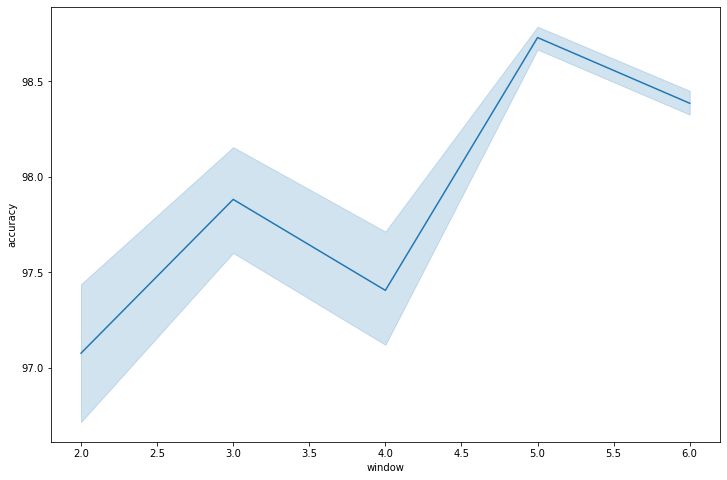

In [32]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc,x='window',y='accuracy')

##### Observe that  9 iterations  achieved a stable accuracy. here we neglect the seemingly high accuracy at lower iterations because we care more about stable performance, which is the key of temporal correction

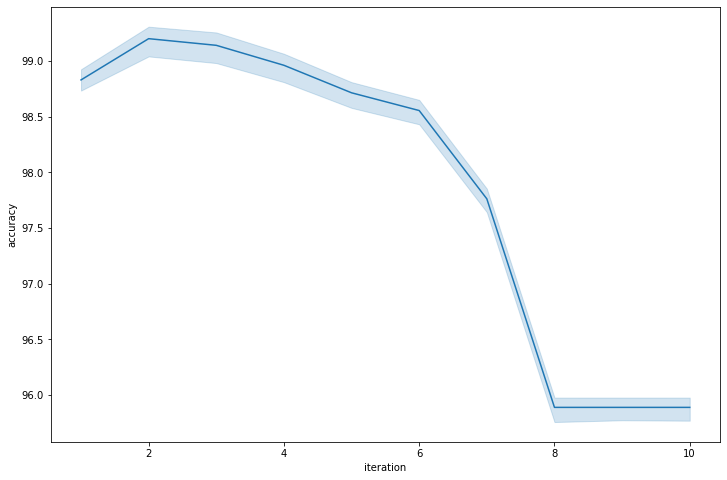

In [34]:
plt.figure(figsize=(12,8))
sns.lineplot(data = Checked_acc[Checked_acc['window'] == 3],
             x='iteration',
             y='accuracy')

##### Observe that the temporal correction have incresed the classification accuracy

1) import the original accuracy df

In [12]:
# access the original acc_df
Sentinel_Acc = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_7_Classification_on_img/Result/Classification_Accuracy_landsat_sentinel.csv')
Landsat_Acc  = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_7_Classification_on_img/Result/Classification_Accuracy.csv')

In [13]:
# Define the classification only use landsat as input
landsat_col = ['Landsat_1990_1992', 'Landsat_1993_1995', 'Landsat_1996_1998','Landsat_1999_2001',
               'Landsat_2002_2004', 'Landsat_2005_2007','Landsat_2008_2010', 'Landsat_2011_2013']

# concatenate all accuracy into one df
Original_landsat = Landsat_Acc[Landsat_Acc['year'].isin(landsat_col)]
Original_acc = pd.concat([Original_landsat,Sentinel_Acc])

In [14]:
# formeting the original addcuracy_df
Original_acc['Year'] = Original_acc['year'].apply(lambda x: x[-9:])
Original_acc

,year,seed,Overall_ACC,Precisioin_non_built,Precisioin_built,Recall_non_built,Recall_built,Year
0,Landsat_1990_1992,0,94.10,93.90,94.30,94.51,93.67,1990_1992
1,Landsat_1990_1992,1,94.20,93.75,94.68,95.06,93.28,1990_1992
2,Landsat_1990_1992,2,95.18,94.37,96.03,96.14,94.22,1990_1992
3,Landsat_1990_1992,3,94.53,93.90,95.18,95.28,93.78,1990_1992
4,Landsat_1990_1992,4,94.89,94.31,95.50,95.70,94.06,1990_1992
...,...,...,...,...,...,...,...,...
15,Sentinel_2017_2019,5,94.83,95.91,93.72,93.99,95.72,2017_2019
16,Sentinel_2017_2019,6,94.03,93.19,94.88,94.83,93.25,2017_2019
17,Sentinel_2017_2019,7,93.61,92.87,94.34,94.13,93.12,2017_2019
18,Sentinel_2017_2019,8,94.26,94.67,93.85,93.96,94.57,2017_2019


2) get the 10-folds threshold correction

In [15]:
# read data
Threshold_acc_df = pd.read_csv('../Process_1_GEE_Python_Classification/Sub_Process_8_Determine_the_threshold_for_the_sum_of_10_random_classification/Result/Threshold_acc_df.csv')

# make the threshold categorical so we can make figures
Threshold_acc_df['Threshold'] = Threshold_acc_df['Threshold'].astype('category')
Threshold_acc_df['Year'] = Threshold_acc_df['Year'].astype('category')

3) make a figure to compare all the accuracy 

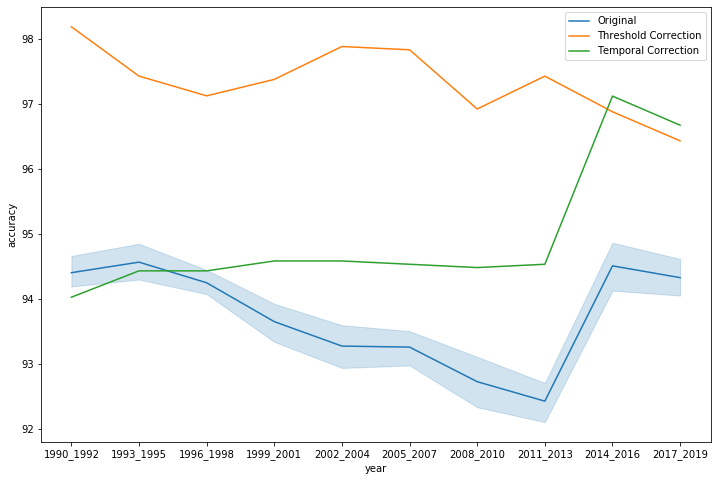

In [16]:
plt.figure(figsize=(12,8))

# original accuracy
sns.lineplot(data = Original_acc,x = 'Year',y='Overall_ACC',label = 'Original')


# threshold correction
sns.lineplot(data = Threshold_acc_df[Threshold_acc_df['Threshold']==4],
             x='Year',
             y='Accuracy',
            label = 'Threshold Correction')


# temporal correction
sns.lineplot(data = Checked_acc[((Checked_acc['window']==3)&
                                 (Checked_acc['iteration']==9))],
             x='year',
             y='accuracy',
            label = 'Temporal Correction')